In [85]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import xgboost
from sklearn import svm
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from kaggle_scoring_metric import score

train_path = "data/train.csv"
test_path = "data/test.csv"

# set_index makes sure we don't use the id column for training
train = pd.read_csv(train_path).set_index("id")
test = pd.read_csv(test_path).set_index("id")

print("Loaded train, test and sample submission")
print(f"   Train shape: {train.shape}, Test shape: {test.shape}")

# date is not present in the test data and is only included for "solely for
# exploratory data analysis"
# partlybad also seems useless
train_x = train.drop(columns=["class4", "date", "partlybad"])
train_x = train_x.loc[:, train_x.columns.str.contains('mean')]
test_x = test.drop(columns=["date", "partlybad"])
test_x = test_x.loc[:, test_x.columns.str.contains('mean')]
train_y = train[["class4"]]

# Standard scaling
cols = train_x.columns
sc = StandardScaler()
train_x_sc = pd.DataFrame(sc.fit_transform(train_x), columns=cols, index=train_x.index)
test_x_sc = pd.DataFrame(sc.transform(test_x), columns=cols, index=test_x.index)

Loaded train, test and sample submission
   Train shape: (450, 103), Test shape: (965, 102)


Percent of variance explained: 99.597%


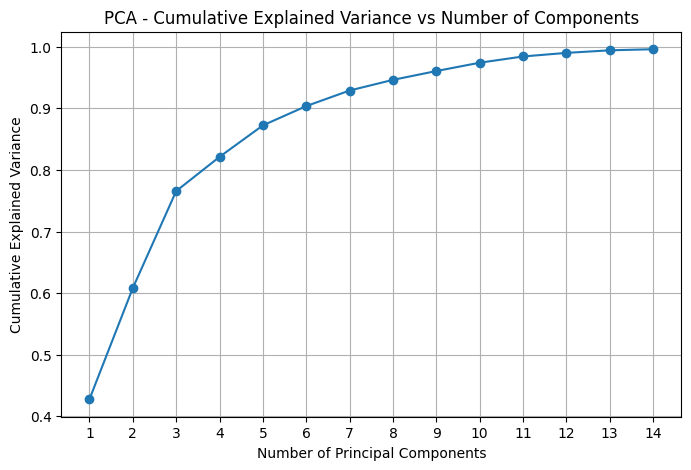

In [86]:
# Fit pca to reduce to ncomponents
num_comp = 14
pca = PCA(n_components=num_comp)
pca.fit(train_x_sc)

# Explained variance
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Percent of variance explained: {explained_variance*100:.3f}%")

# Reform into new dataframe
pca_cols = [f"PCA_{i+1}" for i in range(num_comp)]

# Apply pca to data
train_x_pca = pd.DataFrame(pca.transform(train_x_sc), columns=pca_cols, index=train_x_sc.index)
test_x_pca = pd.DataFrame(pca.transform(test_x_sc), columns=pca_cols, index=test_x_sc.index)

# Explained variance ratio per component
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, num_comp+1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xticks(range(1, num_comp+1))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

In [ ]:
def predict(model, X: pd.DataFrame):
    predicted_class = model.predict(X)
    # returns values for probability of each class. "nonevent" is the 4th class
    # encoded so p("event") = sum of first 3 probabilities
    predicted_proba = model.predict_proba(X)[:, 0:3].sum(axis=1)
    return pd.DataFrame(
        {
            "class4": predicted_class,
            "p": predicted_proba,
        },
        # keeps test data index correct
        index=X.index,
    )


def return_target_df(y: np.ndarray, X):
    return pd.DataFrame(
           {
               "class4": y
           },
        # keeps test data index correct
        index=X.index,
    )


# Train/test split - no pca, apply standard scaling
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2)
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(sc.transform(X_test), columns=X_train.columns, index=X_test.index)

# Train/test split - using pca
#X_train, X_test, y_train, y_test = train_test_split(train_x_pca, train_y, test_size=0.2)

# Include interaction term
#create_inter = PolynomialFeatures(degree=2, interaction_only=True)
#X_train = pd.DataFrame(create_inter.fit_transform(X_train), index=X_train.index)
#X_test = pd.DataFrame(create_inter.transform(X_test), index=X_test.index)

# Convert labels to 1-d array
y_train = np.array(y_train)[:, 0]
y_test = np.array(y_test)[:, 0]

# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Models to train

# Using scaled data
lr_clf = LogisticRegression(
    solver="saga", 
    C=2.0,
    max_iter=10000)
svm_clf = svm.SVC(C=10, gamma=1, kernel='rbf', probability=True)

# Unscaled data
xgb_clf = xgboost.XGBClassifier(
    n_estimators=1000, 
    max_depth=2)
rf_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_depth=3, min_samples_leaf= 5)
dummy_clf = DummyClassifier(strategy="prior")
nb_clf = GaussianNB()
lgbm_clf = lgb.LGBMClassifier(verbose=-1)
knn_clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

models = {
    "xgb": xgb_clf, 
    "lr": lr_clf,
    "svm": svm_clf,
    "rf": rf_clf,
    "dummy": dummy_clf,
    "lgbm": lgbm_clf,
    }

for name, model in models.items():
    print(f"============={name}-model=============")
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"Test accuracy of {name} classifier: {test_acc:.3f}")
    #print(classification_report(y_test, y_pred))
    # k-fold CV
    cv_acc = np.mean(cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=5))
    print(f"Cross validation accuracy: {cv_acc}")

    # Get predictions
    preds = predict(clf, X_test)
    # Convert back to original class labels
    preds["class4"] = le.inverse_transform(preds["class4"])
    target_df = return_target_df(le.inverse_transform(y_test), X_test)
    print(f"Score on training set:")
    score(target_df, preds, 'id')
    print("==================================\n")

=============xgb-model=============
Test accuracy of xgb classifier: 0.622
Cross validation accuracy: 0.6361111111111112
Score on training set:
Binary Accuracy = 0.84444
Perplexity = 1.56830
Multi-Class Accuracy = 0.62222
Combined Score = 0.63279

=============lr-model=============
Test accuracy of lr classifier: 0.622
Cross validation accuracy: 0.7055555555555556
Score on training set:
Binary Accuracy = 0.85556
Perplexity = 1.43043
Multi-Class Accuracy = 0.62222
Combined Score = 0.68245

=============svm-model=============
Test accuracy of svm classifier: 0.611
Cross validation accuracy: 0.6305555555555555
Score on training set:
Binary Accuracy = 0.81111
Perplexity = 1.48531
Multi-Class Accuracy = 0.61111
Combined Score = 0.64564

=============rf-model=============
Test accuracy of rf classifier: 0.656
Cross validation accuracy: 0.6472222222222223
Score on training set:
Binary Accuracy = 0.86667
Perplexity = 1.36456
Multi-Class Accuracy = 0.65556
Combined Score = 0.71922

============

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2)
#X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
#X_test = pd.DataFrame(sc.transform(X_test), columns=X_train.columns, index=X_test.index)

#X_train, X_test, y_train, y_test = train_test_split(train_x_pca, train_y, test_size=0.2)

# Convert labels to 1-d array
y_train = np.array(y_train)[:, 0]
y_test = np.array(y_test)[:, 0]

# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# =========================================================
# Experimentation, not optimal and might not make any sense
# =========================================================
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 4, 6, -1],
    "learning_rate": [0.01, 0.05, 0.1],
    #"num_leaves": [7, 15, 31],
    #"subsample": [0.6, 0.8, 1.0],
    #"colsample_bytree": [0.5, 0.7, 1.0],
    #"min_child_samples": [5, 10, 20],
    #"reg_alpha": [0, 0.1, 1.0],
    #"reg_lambda": [0, 1.0, 2.0]
}
gs = GridSearchCV(lgb.LGBMClassifier(verbose=-1), param_grid, verbose=1, n_jobs=-1).fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)

model = lgb.LGBMClassifier(verbose=-1, **gs.best_params_).fit(X_train, y_train)

preds = predict(model, X_test)
# Convert back to original class labels
preds["class4"] = le.inverse_transform(preds["class4"])
target_df = return_target_df(le.inverse_transform(y_test), X_test)
print(f"Score on training set:")
score(target_df, preds, 'id')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
# LR best result (scaled):
#{'C': 0.5, 'max_iter': 2000, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}
#Score: 0.7631256798547938

# SVC best result (scaled):
#{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
#Score: 0.7370709242894385

# RF best result (unscaled):
#{'max_depth': None, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
#Score: 0.7242118322499462

# XGB best result (unscaled):
#{'colsample_bytree': 0.7, 'eval_metric': 'mlogloss', 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'subsample': 0.6}
#Score: 0.7685731375658954

In [18]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
import seaborn as sns

from kaggle_scoring_metric import score

train_path = "data/train.csv"
test_path = "data/test.csv"

# set_index makes sure we don't use the id column for training
train = pd.read_csv(train_path).set_index("id")
test = pd.read_csv(test_path).set_index("id")

print("Loaded train, test and sample submission")
print(f"   Train shape: {train.shape}, Test shape: {test.shape}")


# date is not present in the test data and is only included for "solely for
# exploratory data analysis"
# partlybad also seems useless
train_x = train.drop(columns=["class4", "date", "partlybad"])
test_x = test.drop(columns=["date", "partlybad"])
train_y = train["class4"]

# model = RandomForestClassifier(n_estimators=300, n_jobs=-1, max_depth=8).fit(
#     train_x, train_y
# )


def predict(model: RandomForestClassifier, X: pd.DataFrame):
    predicted_class = model.predict(X)
    # returns values for probability of each class. "nonevent" is the 4th class
    # encoded so p("event") = sum of first 3 probabilities
    predicted_proba = model.predict_proba(X)[:, 0:3].sum(axis=1)
    return pd.DataFrame(
        {
            "class4": predicted_class,
            "p": predicted_proba,
        },
        # keeps test data index correct
        index=X.index,
    )


# random experimentation, not optimal and might not make any sense
param_grid = [
    {
        "n_estimators": np.linspace(100, 1000, 4, dtype=np.int64),
        "max_depth": [3, 7, 15, None],
        "min_samples_leaf": np.linspace(1, 8, 4, dtype=np.int64),
    }
]
gs = GridSearchCV(RandomForestClassifier(), param_grid, verbose=2, n_jobs=-1).fit(
    train_x, train_y
)
print(gs.best_params_)
print(gs.best_score_)

model = RandomForestClassifier(**gs.best_params_).fit(train_x, train_y)
features_importances = sorted(
    zip(model.feature_importances_, model.feature_names_in_), key=lambda x: x[0]
)
print("importances:", features_importances)


# score on training set
score(train[["class4"]], predict(model, train_x), "id")

test_prediction = predict(model, test_x)
test_prediction.to_csv("submission.csv", index_label="id")

Loaded train, test and sample submission
   Train shape: (450, 103), Test shape: (965, 102)
Fitting 5 folds for each of 64 candidates, totalling 320 fits
{'max_depth': 3, 'min_samples_leaf': np.int64(5), 'n_estimators': np.int64(1000)}
0.6444444444444445
importances: [(np.float64(0.0005798363009004472), 'H2O672.std'), (np.float64(0.0006697164866069592), 'H2O504.std'), (np.float64(0.0007129427229751539), 'H2O168.std'), (np.float64(0.0007169551097229001), 'H2O42.std'), (np.float64(0.0007302230557379489), 'H2O84.std'), (np.float64(0.0008637948168309272), 'NO42.std'), (np.float64(0.0008771617941448548), 'SWS.std'), (np.float64(0.0009073958355408122), 'Pamb0.std'), (np.float64(0.0009339119398886752), 'O3672.mean'), (np.float64(0.0009752965903451859), 'SO2168.std'), (np.float64(0.0010174125595774407), 'NOx168.std'), (np.float64(0.0010386340879958164), 'CO2504.mean'), (np.float64(0.0011060738627470198), 'H2O336.std'), (np.float64(0.0013107464084168884), 'CO242.mean'), (np.float64(0.0014697332